In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D

TRAIN_DIR = 'train'
VALIDATE_DIR = 'validate'
TEST_DIR = 'test'
AUGMENTED_DIR = 'augmented'

image_width = 150
image_height = 150
pool_size = 2
learning_rate = 1e-3 # 0.0004
batch_size = 32
epochs=10

classes = {'dog': 1, 'cat': 0}


Using TensorFlow backend.


In [2]:
def read_image(dir_path, file_name):
    image_path = os.path.join(dir_path, file_name)
    raw_image = load_img(image_path, target_size=(image_width, image_height))
    if raw_image is not None:
        img_array = img_to_array(raw_image)
        return img_array


In [3]:
def display_image(image, prediction=None):
    label_name = None
    accuracy = 0.0
    if prediction >= 0.5:
        label_name = 'Dog'
        accuracy = prediction
    else:
        label_name = 'Cat'
        accuracy = 1-prediction
    
    plt.title('label: {}, accuracy: {:.2%}'.format(label_name, accuracy))
    plt.imshow(array_to_img(image))
    plt.show()


In [4]:
def load_train_data(is_train=True):
    features = []
    labels = []
    file_list = os.listdir(TRAIN_DIR)
    bucket_size = int(len(file_list)*0.9)

    if is_train:
        file_list = file_list[:bucket_size]
    else:
        file_list = file_list[bucket_size:]
    
    shuffle(file_list)
    for file_name in tqdm(file_list):
        # 1 = dog, 0 = cat
        label = classes[file_name.split('.')[0]]
        image = read_image(TRAIN_DIR, file_name)
        if image is not None and label is not None:
            features.append(image)
            labels.append(label)
    return np.array(features), labels

def load_test_data():
    test_data = []
    names = []
    file_list = os.listdir(TEST_DIR)
    for file_name in tqdm(file_list):
        image = read_image(TEST_DIR, file_name)
        if image is not None:
            test_data.append(image)
            names.append(file_name.split('.')[0])
    return np.array(test_data), names


In [5]:
X_train, y_train = load_train_data()


100%|██████████| 22500/22500 [01:04<00:00, 348.65it/s]


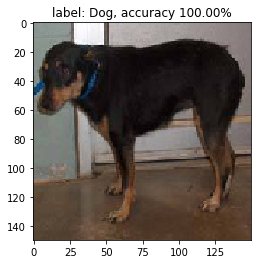

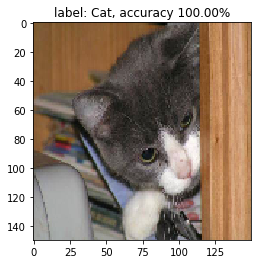

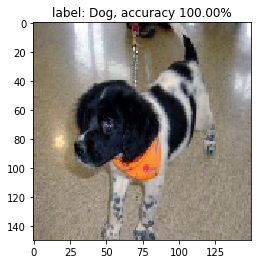

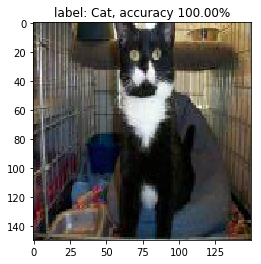

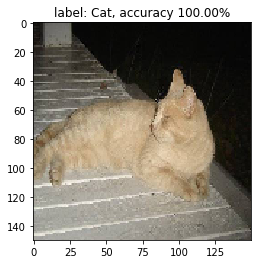

In [6]:
for i in range(5):
    display_image(X_train[i], y_train[i])


In [7]:
model = Sequential()

model.add(Conv2D(32, (5,5), input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)             0         
__________

In [8]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])


In [9]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [10]:
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation')

history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.n/batch_size,
    validation_steps=validation_generator.n/batch_size,
    epochs=epochs,
    verbose=1)


Epoch 1/10
563/562 [==============================] - 304s 540ms/step - loss: 0.6467 - acc: 0.6326 - val_loss: 0.5945 - val_acc: 0.6918
Epoch 2/10
563/562 [==============================] - 304s 540ms/step - loss: 0.5262 - acc: 0.7430 - val_loss: 0.5163 - val_acc: 0.7440
Epoch 3/10
563/562 [==============================] - 305s 542ms/step - loss: 0.4427 - acc: 0.7941 - val_loss: 0.5172 - val_acc: 0.7531
Epoch 4/10
563/562 [==============================] - 320s 568ms/step - loss: 0.3428 - acc: 0.8487 - val_loss: 0.5695 - val_acc: 0.7720
Epoch 5/10
563/562 [==============================] - 324s 575ms/step - loss: 0.2289 - acc: 0.9063 - val_loss: 0.6219 - val_acc: 0.7700
Epoch 6/10
563/562 [==============================] - 328s 582ms/step - loss: 0.1398 - acc: 0.9487 - val_loss: 0.7128 - val_acc: 0.7682
Epoch 7/10
563/562 [==============================] - 334s 593ms/step - loss: 0.0899 - acc: 0.9681 - val_loss: 0.8584 - val_acc: 0.7549
Epoch 8/10
563/562 [============================

In [11]:
model.save('model.h5')
model.save_weights('weights.h5')


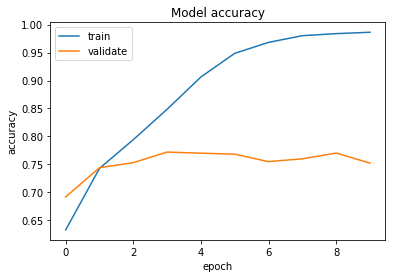

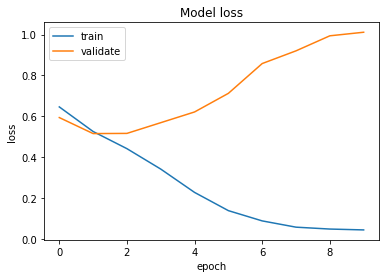

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()


In [13]:
X_evaluate, y_evaluate = load_train_data(False)
X_evaluate /= 255

evaluation = model.evaluate(X_evaluate, y_evaluate)
print('Model loss: %s\nModel accuracy: %s' % (evaluation[0], evaluation[1]))


100%|██████████| 2500/2500 [00:07<00:00, 325.81it/s]


2500/2500 [==============================] - 11s 4ms/step
Model loss: 0.9581744208574295
Model accuracy: 0.7492


In [14]:
X_test, names = load_test_data()
X_test /= 255

predictions = model.predict(X_test)


100%|██████████| 12500/12500 [00:38<00:00, 324.36it/s]


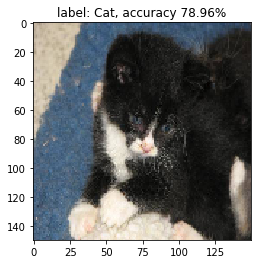

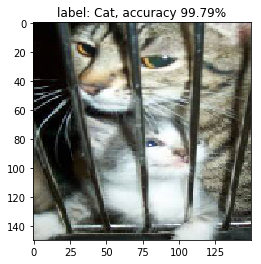

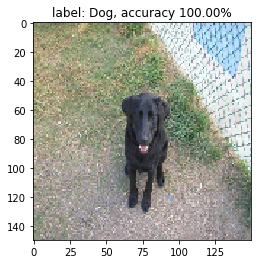

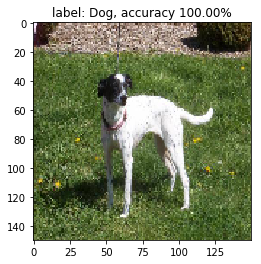

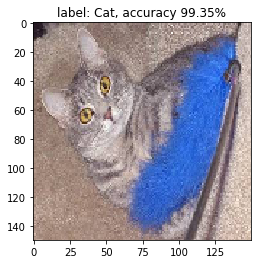

In [15]:
for i in range(5):
    display_image(X_test[i], predictions[i][0])


In [16]:
with open('dogs-vs-cats-results.csv', 'w') as f:
    f.write('id,label\n')
    for i in tqdm(range(predictions.shape[0])):
        f.write('{},{}\n'.format(names[i], predictions[i][0]))


100%|██████████| 12500/12500 [00:00<00:00, 409072.68it/s]
